In [1]:
# Constants
S3_BUCKET_PATH="s3://ads-datasets/wordle-player"
S3_FLD_CSV="flat"
S3_FLD_PQT="parquet"

FILENAME_GAMETURNS_CSV = "game-turns.csv"
FILENAME_GAMETURNS_PQT = "game-turns.parquet"
FILENAME_VALIDWORDATTEMPTS_CSV = "valid-word-attempts.csv"
FILENAME_VALIDWORDATTEMPTS_PQT = "valid-word-attempts.parquet"

WORD_LENGTH = 5

In [2]:
# Helper dict to locate files in s3
src_raw = {
  S3_FLD_CSV: {
    'folder': S3_FLD_CSV,
    'file': {
      'gameturns': FILENAME_GAMETURNS_CSV,
      'validwordattempts': FILENAME_VALIDWORDATTEMPTS_CSV,
    }
  },
  S3_FLD_PQT: {
    'folder': S3_FLD_PQT,
    'file': {
      'gameturns': FILENAME_GAMETURNS_PQT,
      'validwordattempts': FILENAME_VALIDWORDATTEMPTS_PQT,
    }
  }
}

In [3]:
import awswrangler as wr
import os

# Loads the raw data
def load_raw_data(format=S3_FLD_PQT, filename='gameturns'):
  bucket_path = S3_BUCKET_PATH
  fld_format = src_raw[format]['folder']
  file_name = src_raw[format]['file'][filename]

  path = os.path.join(bucket_path, fld_format, file_name)

  return wr.s3.read_parquet(path=path)

In [4]:
# Inspect game turns data from parquet 
df = load_raw_data(format=S3_FLD_PQT, filename='gameturns')
df.head()

,gameId,turns
0,c7q67hdsi8ns738u2vm0,"[{'guess': 'LEACH', 'isValid': True, 'tryResul..."
1,c7q67klsi8ns738u36dg,"[{'guess': 'ACXNX', 'isValid': False, 'tryResu..."
2,c7q67ktsi8ns738u36vg,"[{'guess': 'ALUZV', 'isValid': False, 'tryResu..."
3,c7q67l5si8ns738u37ag,"[{'guess': 'UBUHK', 'isValid': False, 'tryResu..."
4,c7q67l5si8ns738u37fg,"[{'guess': 'VHERY', 'isValid': False, 'tryResu..."


In [5]:
# Inspect valid word attempt data from parquet 
df = load_raw_data(format=S3_FLD_PQT, filename='validwordattempts')
df.head()

,guess,isValid,gameId
0,LEACH,True,c7q67hdsi8ns738u2vm0
1,BNVUX,False,c7q67hdsi8ns738u2vm0
2,NHBLJ,False,c7q67hdsi8ns738u2vm0
3,JZJKV,False,c7q67hdsi8ns738u2vm0
4,HCPXK,False,c7q67hdsi8ns738u2vm0


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

letter_cols = [f'l{n}' for n in range(WORD_LENGTH)]

# Prepare valid words dataset
def prepare_valid_word_data(format=S3_FLD_PQT, filename='validwordattempts', test_size=0.1):
  df = load_raw_data(format=S3_FLD_PQT, filename='validwordattempts')

  # Split each guess word to letters in individual columns
  df = df.join(
    pd.DataFrame(
      [list(w) for w in df['guess']], 
      columns=letter_cols)
    )
  
  # Training-testing split
  y = df['isValid'].astype(int)
  X = df.drop(['isValid'], axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

  return X_train, X_test, y_train, y_test


In [7]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

# Train a classifier
def train_classifier(X_train, y_train, clf=LogisticRegression()):
  global ohe 

  # One-hot encode the letters
  ohe = OneHotEncoder(handle_unknown='error')
  X_train_ohe = ohe.fit_transform(X_train[letter_cols])

  # Fit the training data
  clf.fit(X_train_ohe, y_train.to_numpy())
  return clf


# Predict from a trained classifier
def predict_from_classifier(X, clf):
  global ohe
  X_ohe = ohe.transform(X[letter_cols])

  return clf.predict(X_ohe)


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

# Plot results as a confusion matrix
def plot_confusion_matrix(name, prediction, y_test):
  accuracy = accuracy_score(prediction, y_test)
  f1 = f1_score(prediction, y_test)
  precision = precision_score(prediction, y_test)
  recall = recall_score(prediction, y_test)

  cf_matrix = confusion_matrix(prediction, y_test)

  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  summary_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(accuracy,precision,recall,f1)

  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)

  figsize = plt.rcParams.get('figure.figsize')
  plt.figure(figsize=figsize)
  sns.heatmap(
    cf_matrix/np.sum(cf_matrix), 
    annot=labels,
    fmt='', 
    cmap='Blues')
  plt.xlabel(name + '\n' + summary_text)
  

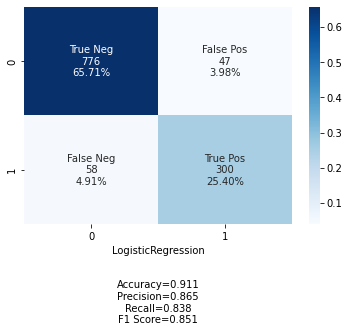

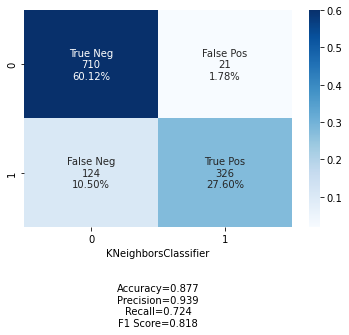

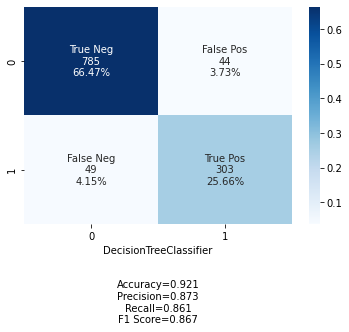

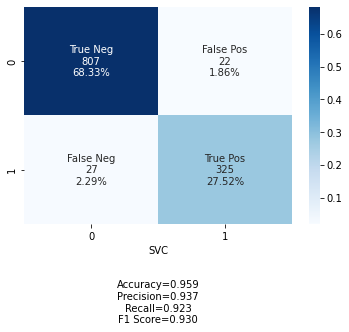

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Try a few different classifiers
clf_dict = {
  'LogisticRegression': LogisticRegression(),
  'KNeighborsClassifier': KNeighborsClassifier(),
  'DecisionTreeClassifier': DecisionTreeClassifier(),
  'SVC': SVC(),
}

# Load and prep the data
X_train, X_test, y_train, y_test = prepare_valid_word_data()

# Train and plot the confusion matrices
for name in clf_dict:
  clf = clf_dict[name]
  model = train_classifier(X_train, y_train, clf)
  prediction = predict_from_classifier(X_test, model)
  plot_confusion_matrix(name, prediction, y_test)
